# Explore PICO data

In [62]:
# generic imports
import ast
import collections
import re
import spacy
import scispacy
import time
import numpy as np
from collections import Counter
from itertools import groupby
import itertools
from operator import itemgetter

# DS imports
import pandas as pd

# visualiation imports 
from matplotlib_dashboard import MatplotlibDashboard
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
import seaborn as sns

# NLP imports
import spacy

In [ ]:
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')

In [2]:
load_data = '/mnt/nas2/data/systematicReview/semeval2023/data/parsed/st2_train_parsed.tsv'

In [3]:
df = pd.read_csv(load_data, sep='\t')

In [4]:
df.head()

,Unnamed: 0,post_id,subreddit_id,claim,stage2_labels,text,labels_char,claim_offsets,tokens,labels
0,0,sn9u41,t5_2s23e,I read an old thread on here that someone said...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Tysabri experiences\nHi all\n\nI just had my 3...,"[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","(508, 724)","['Tysabri', 'experiences', 'Hi', 'all', 'I', '...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,p7j49y,t5_2syer,"I have read that gout can't be cured, that it'...","[{""crowd-entity-annotation"":{""entities"":[{""end...",Crazy amount of sardines caused gout (possibly...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1401, 1654)","['Crazy', 'amount', 'of', 'sardines', 'caused'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,smgy0q,t5_2s3g1,I always read stories of people who suffer fro...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Im sorry for intruding but I just want to say ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(302, 419)","['Im', 'sorry', 'for', 'intruding', 'but', 'I'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,sxglhl,t5_2s3g1,Our results indicate that the addition of prob...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Is Bacillus coagulans supplementation plus low...,"[0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","(1442, 1617)","['Is', 'Bacillus', 'coagulans', 'supplementati...","[0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,4,rxyk1d,t5_2s1h9,Ive read that amnesia always followed a tonic ...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",[deleted by user]\n[removed],N.A.,N.A.,[['N.A.']],[['N.A.']]


In [43]:
picos_mapping = {'population': 1, 'intervention':2, 'outcome':3, 'oos':0}

### Reddit post lengths

In [21]:
lengths = [ len( ast.literal_eval(i)) for i in df.tokens ]

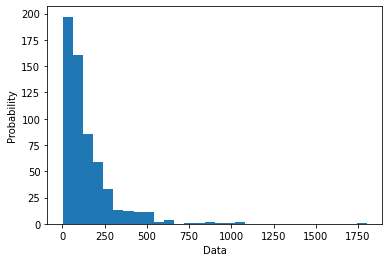

In [23]:
plt.hist(lengths, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

### class vs out-of-the-class tokens

In [6]:
def class_ratio(labels, entity):
    
    entity_num = picos_mapping[entity]
    
    out_of_span_counter = 0
    class_counter = 0
    
    for i in labels:
        lab_i = ast.literal_eval(i)
        if len(lab_i)>1:
            counts = collections.Counter( lab_i )
            counts = dict( counts )
            out_of_span_counter = out_of_span_counter + counts[0]
            if entity_num in counts:
                class_counter = class_counter + counts[entity_num]
                
    count_summary = {str(entity): class_counter, 'oos':out_of_span_counter}
                
    return count_summary

{'population': 469, 'oos': 82592}
{'intervention': 882, 'oos': 82592}
{'outcome': 879, 'oos': 82592}


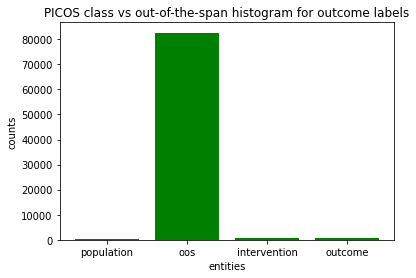

In [8]:
for x in [ 'population', 'intervention', 'outcome' ]:
    count_summary = class_ratio(df.labels, x)
    print( count_summary )
    plt.bar(list(count_summary.keys()), count_summary.values(), color='g')
    plt.title(f'PICOS class vs out-of-the-span histogram for {x} labels')
    plt.xlabel('entities')
    plt.ylabel('counts')

### Inspect the PICO annotations

In [73]:
picos_colors_mapping = {'population': 'green', 'intervention': 'red', 'outcome': 'blue', 'oos':'black'}

In [13]:
def inspect_annots(entity):
    terms_all = []
    terms_lengths = []

    for counter, (tok, lab) in enumerate(zip(df.tokens.values, df.labels.values)):
        
        tok = ast.literal_eval(tok)
        lab = ast.literal_eval(lab)
        
        
        captured_ind = []
        captured_cons_ind = []
        for counter_i, (t, l) in  enumerate(zip(tok, lab)):
            if l == picos_mapping[entity]:
                captured_ind.append( counter_i )

        for k, g in groupby(enumerate(captured_ind), lambda ix : ix[0] - ix[1]):
            label_indices = list(map(itemgetter(1), g))
            captured_cons_ind.append( label_indices )

        #print('\n-----------------------------------------------')

        for x in captured_cons_ind:
            #print(x)
            p_term = [tok[x_i] for x_i in x]
            terms_lengths.append( len(p_term) )
            p_term = ' '.join(p_term)
            terms_all.append( p_term )
            
            
    return terms_lengths, terms_all

In [14]:
def plot_common_words(description_list, n):
    # Assign the Counter instance `most_common` call to a variable:
    word_frequency = Counter(" ".join(description_list).split()).most_common(n)

    # `most_common` returns a list of (word, count) tuples
    words = [word for word, _ in word_frequency]
    counts = [counts for _, counts in word_frequency]
    
    fig = plt.figure(figsize=(7, 5))
    plt.bar(words, counts, color = picos_colors_mapping[picos_i])
    plt.title("10 most frequent tokens in the list")
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.xticks(rotation=45, ha='right')

    plt.show()

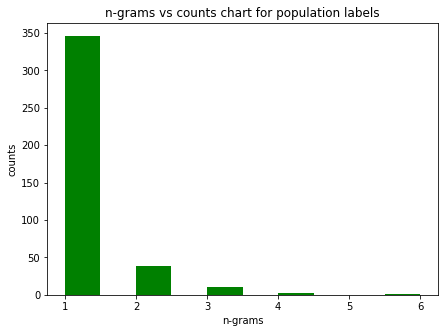

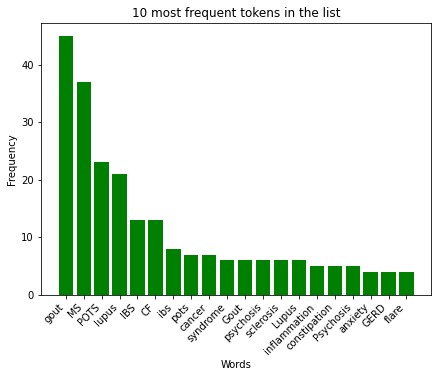

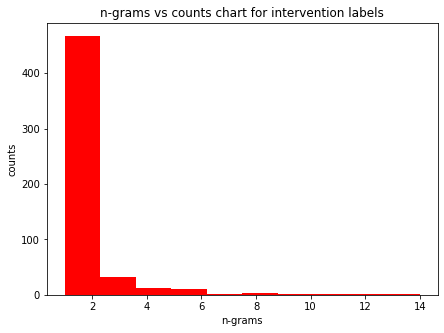

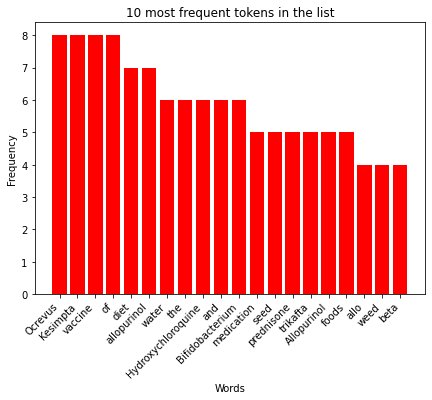

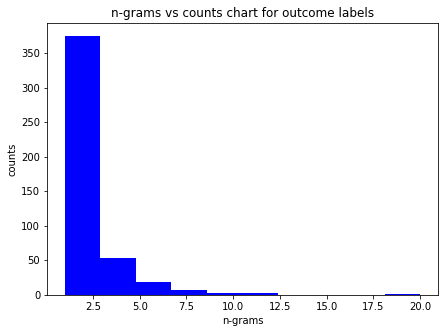

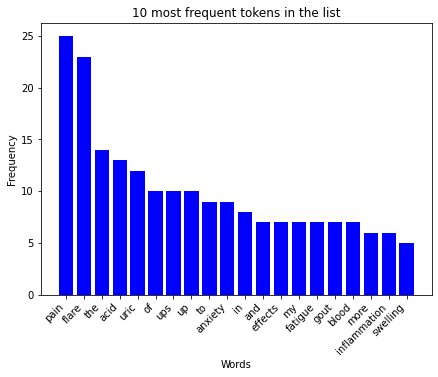

In [16]:
for picos_i in [ 'population', 'intervention', 'outcome' ]:
    
    terms_i_lengths, terms_i_all = inspect_annots(picos_i)   

    fig = plt.figure(figsize=(7, 5))
    plt.hist( terms_i_lengths, bins=10, color = picos_colors_mapping[picos_i]) 
    plt.title(f'n-grams vs counts chart for {picos_i} labels')
    plt.xlabel('n-grams')
    plt.ylabel('counts')
        
    plt.show()
    
    plot_common_words(terms_i_all, 20)

In [44]:
'''
Some notes:

Participants: Lots of abbreviations. Consider them in the training and could use that in augmentation.
'''

'\nSome notes:\n\nParticipants: Lots of abbreviations. Consider them in the training and could use that in augmentation.\n'

### Class overlap

In [17]:
def class_overlap(tokens, labels):
    
    par = []
    inter = []
    out = []
    oos = []
    
    for t, l in zip(tokens, labels):
        tok_i = ast.literal_eval(t)
        lab_i = ast.literal_eval(l)
        
        if len(lab_i)>1:
            
            for i,j in zip(tok_i, lab_i):
                if j == 0:
                    oos.append(i)
                if j == 1:
                    par.append(i)
                if j == 2:
                    inter.append(i)
                if j == 3:
                    out.append(i)

    return { 'participant': par, 'intervention': inter, 'outcome': out, 'oos': oos }


tokens_dict = class_overlap(df.tokens, df.labels)

In [18]:
for pair in itertools.combinations(['participant','intervention','outcome','oos'], 2):
    
    t1 = tokens_dict[ pair[0] ]
    t2 = tokens_dict[ pair[1] ]
    
    common = list(set(t1).intersection(t2))
    print( f'Common tokens between {pair[0]} and {pair[1]}: {common} \n' )
    print( f'Total number of common tokens between {pair[0]} and {pair[1]}: {len(common)} \n' )
    print(' -------------------------------------------------------------------- ')

Common tokens between participant and intervention: ['vaccines', 'cancer', 'inflammation', 'with', 'certain', 'Acid', 'SLE', 'Cystic', 'bupropion', 'tachycardia', 'cf', 'pylori', 'covid', 'diet', 'patients', 'stress', 'COVID', 'high', 'Fibrosis', 'alcohol', 'tysabri', 'ANA', 'acid', 'Syndrome', 'healthy', 'pots', 'blood'] 

Total number of common tokens between participant and intervention: 27 

 -------------------------------------------------------------------- 
Common tokens between participant and outcome: ['constipated', 'up', 'immune', 'cancer', 'Psychosis', 'dysfunction', 'uric', 'diarrhea', 'inflammation', 'GERD', 'Acid', 'Depression', 'Gout', 'attack', 'to', 'POTS', 'depression', 'autoimmune', 'Multiple', 'pelvic', 'pressure', 'Sclerosis', 'rash', 'health', 'stress', 'sclerosis', 'mental', 'high', 'GI', 'gerd', 'hernia', 'esophagus', 'seizure', 'vertigo', 'Lupus', 'multiple', 'acid', 'lupus', 'Sjögrens', 'gout', 'bowel', 'seizures', 'psychosis', 'asthma', 'blood', 'bad', 'fla

### POS tag distributions

In [82]:
from spacy.glossary import GLOSSARY
lookup_dict = GLOSSARY

In [118]:
lookup_dict

{'ADJ': 'adjective',
 'ADP': 'adposition',
 'ADV': 'adverb',
 'AUX': 'auxiliary',
 'CONJ': 'conjunction',
 'CCONJ': 'coordinating conjunction',
 'DET': 'determiner',
 'INTJ': 'interjection',
 'NOUN': 'noun',
 'NUM': 'numeral',
 'PART': 'particle',
 'PRON': 'pronoun',
 'PROPN': 'proper noun',
 'PUNCT': 'punctuation',
 'SCONJ': 'subordinating conjunction',
 'SYM': 'symbol',
 'VERB': 'verb',
 'X': 'other',
 'EOL': 'end of line',
 'SPACE': 'space',
 '.': 'punctuation mark, sentence closer',
 ',': 'punctuation mark, comma',
 '-LRB-': 'left round bracket',
 '-RRB-': 'right round bracket',
 '``': 'opening quotation mark',
 '""': 'closing quotation mark',
 "''": 'closing quotation mark',
 ':': 'punctuation mark, colon or ellipsis',
 '$': 'symbol, currency',
 '#': 'symbol, number sign',
 'AFX': 'affix',
 'CC': 'conjunction, coordinating',
 'CD': 'cardinal number',
 'DT': 'determiner',
 'EX': 'existential there',
 'FW': 'foreign word',
 'HYPH': 'punctuation mark, hyphen',
 'IN': 'conjunction, su

In [84]:
pos_2_num = dict( zip(lookup_dict.keys(), [*range(len(lookup_dict))]) )

In [38]:
def getPOStags(value):
    
    value = ast.literal_eval(value)
    pos = []
    
    for v in value:
        if type(v) == str:
            doc = en(v)
            tok_pos = [ token.tag_ for token in doc ]
            pos.append( tok_pos[0] )
        else:
            pos.append( 'N.A.' )

    return pos

In [41]:
df['pos'] = df.tokens.progress_apply(getPOStags)

  0%|          | 0/597 [00:00<?, ?it/s]

In [131]:
def get_pos_distribution(pos, lab, ent):
    
    pos_ent = []
    
    for p, j in zip( pos, lab ):
            
        #p = ast.literal_eval(i)
        l = ast.literal_eval(j)
    
        for p_i, l_i in zip(p, l):
            if l_i == picos_mapping[ent]:
                pos_ent.append( p_i )
    
    pos_counts = collections.Counter(pos_ent)
    pos_counts = dict( pos_counts.most_common(25) )
    
    fig = plt.figure(figsize=(12, 5))
    plt.bar(pos_counts.keys(), pos_counts.values(), color = picos_colors_mapping[ent])
    plt.title(f'POS tags counts in the {ent} class')
    plt.ylabel("Counts")
    plt.xlabel("POS tags")
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    # Distribution
    # create figure and axes
    pos_ent_num = [pos_2_num[i] for i in pos_ent]
    graph = sns.displot( data=pos_ent_num, stat='count', height=4, aspect=1.5, kde=True )
    
    return pos_counts

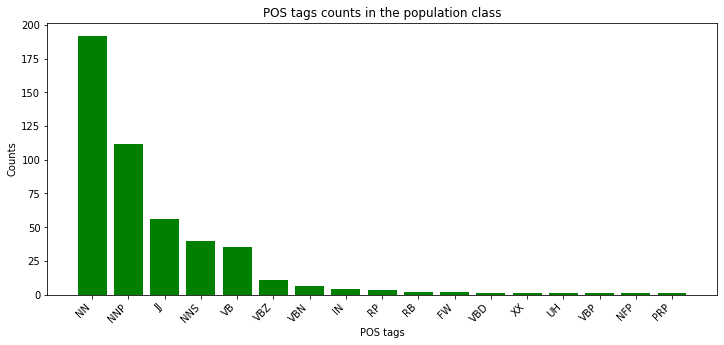

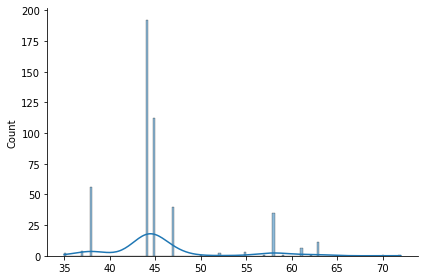

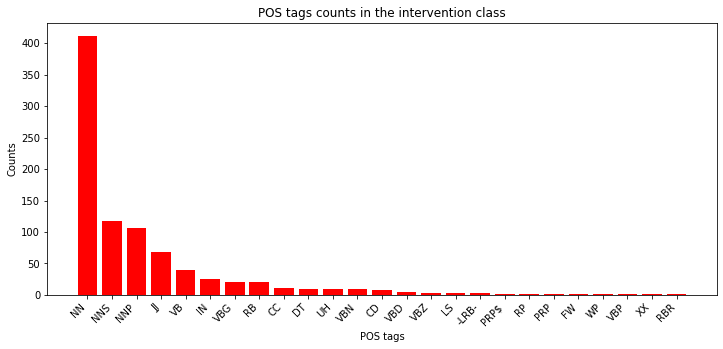

In [ ]:
for i in ['population', 'intervention', 'outcome','oos']:
    get_pos_distribution( df.pos, df.labels , i )

Notes: POS tag distributions are different/discriminatory for the PICOS tags

### Examine individual PICO

In [24]:
for picos_i in [ 'outcome' ]:
    
    _, terms_i_all = inspect_annots(picos_i)
    
    for i in list(set(terms_i_all)):
        print(i)

Confusion
reduce your symptoms
intense nausea
Sibo
chest pressure
wheezing
smell different
headache
infection
stabbed
stiffness
high uric acid
remission state
inflammation-induced Gout
bloats
doubled
scarring
dry skin
bruised
stomach problems
tight chest
tired
Itchy
Bloated
Remission
cramps
nausea/dizzy
screen for CF
do have flare ups
to mitigate any pain from flare-ups caused by the Allo
autoimmune disease
flare up
do more harm than good
Stress
burp
sore throats.
worsening of old symptoms
battery acid taste in your mouth
anxious
effect bowel movements
liver damage
cholesterol
pain
severity has decreased
joints
blistering
cold
curcumin
my heart is okay
muscle cramps
aching
achieve targeted uric acid serum levels
nerve issues
cardiac arrest
fevers
symptoms in the extremities
delusions
Anxiety to a point where I thought I had heart and brain problems Depression Heart palpitations Fatigue Brain fog Numbness
helped quite a bit to manage my UA levels
less sedating
prevent future flare-ups
b

### Examine social media posts

In [25]:
for i in df.text:
    print(i)
    print('-------------------------------')

Tysabri experiences
Hi all

I just had my 3rd tysabri infusion today. I was wondering if any other people on tysabri notice they get a slight worsening of old symptoms hours after infusion? For example, normally my hug only is around the front of my chest, but its wrapped around my back now like it had in the past. Or maybe thats just what back pain feels like  So perhaps Im just getting typical side effects. I never have any side effects when Im monitored in the hour after my actual IV drip, though. 

I read an old thread on here that someone said she thinks that her immune system is retaliating because it can no longer cross the blood brain barrier. That doesnt sound scientific lol but it makes sense to me kinda. Did anyone else have trouble with their first several tysabri infusions? And how long did it take you to adjust and/or see improvement? This is my very first DMT so I have no experience with anything else. Im hoping I can see some symptom improvement in the future.
---------